# Напоминание из теории

В случае оптимального байесовского классификатора разделяющая поверхность будет задаваться уравнением

$$
\mathbb{P}(C_1|x) = \mathbb{P}(C_2|x) \Longleftrightarrow \mathbb{P}(x|C_1)\mathbb{P}(C_1) = \mathbb{P}(x|C_2)\mathbb{P}(C_2).
$$

Теперь обсудим пример построения порождающей модели. Естественно, на основе нормального распределения или гауссианов. Пусть

$$
\mathbb{P}(x|C_i) = \mathbb{N}(x|\mu_i, \Sigma_i).
$$

Разделяющая поверхность будет иметь вид

$$
\ln \mathbb{P}(C_1) - \frac{1}{2}\ln |\Sigma_1| - \frac{1}{2}(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1) = \ln \mathbb{P}(C_2) - \frac{1}{2}\ln |\Sigma_2| - \frac{1}{2}(x-\mu_2)^{T}\Sigma_2^{-1}(x-\mu_2).
$$

Понятно, что разделяющая поверхность квадратичная. Для оценки параметров $\mu_i$ и $\Sigma_i$ имеет смысл использовать соответствующие выборочные характеристики (выборочное среднее и выборочная ковариационная матрица). Оценить $\mathbb{P}(C_i)$ можно долей числа элементов соответствующего класса.

# LDA

В рамках предположения, что $\Sigma_1 = \Sigma_2$ и

$$
\Sigma =  \frac{|C_1|}{|C_1| + |C_2|}\Sigma_1 + \frac{|C_2|}{|C_1| + |C_2|}\Sigma_2,
$$

где

$$
\Sigma_i = \frac{1}{|C_i|}\sum_{x\in C_i}\left(x-\mu_i\right)\left(x-\mu_i\right)^T
$$

разделяющая поверхность будет иметь вид гиперплоскости

$$
\left(\mu_2 - \mu_1\right)\Sigma^{-1}x + \frac{1}{2} \left(\mu_1^{T}\Sigma^{-1}\mu_1 - \mu_2^{T}\Sigma^{-1}\mu_2\right) + \ln \frac{\mathbb{P}(C_2)}{\mathbb{P}(C_1)} = 0.
$$

### Генерация данных

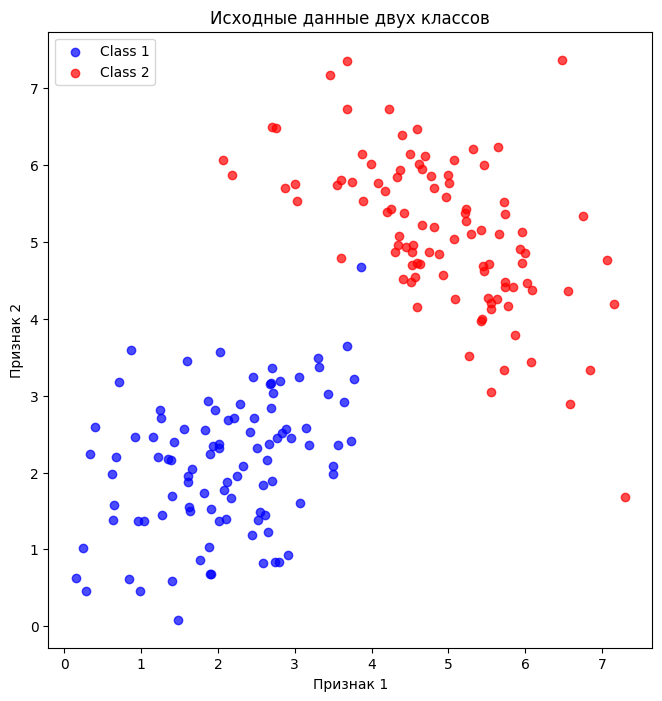

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Генерация данных
np.random.seed(42)

class_1_size = 100
class_2_size = 100

class_1 = np.random.multivariate_normal(mean=[2, 2], cov=[[1, 0.5], [0.5, 1]], size=class_1_size)
class_2 = np.random.multivariate_normal(mean=[5, 5], cov=[[1, -0.5], [-0.5, 1]], size=class_2_size)

# Объединение данных
X = np.vstack((class_1, class_2))
y = np.hstack((np.zeros(100), np.ones(100)))

# Визуализация данных
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.legend()
plt.title('Исходные данные двух классов')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

## Вычисление параметров модели

In [ ]:
# Оценка среднего

def get_mu(class_objects):
  """
  Параметры
  ----------
  class_objects : {array-like} формы (n_samples, n_features)
      Объекты одного класса, где `n_samples` — число объектов
      и `n_features` — число признаков.

  Что возвращается
  -------
  mu : вектор из координат центроида класса
  """
  mu = np.mean(class_objects, axis=0)
  return mu

mu_1 = get_mu(class_1)
mu_2 = get_mu(class_2)

assert np.isclose(mu_1, np.array([2.08307042, 2.11709274])).all() and np.isclose(mu_2, np.array([4.91067717, 5.13281048])).all()

In [ ]:
# Обращенная матрица ковариаций

def get_Sigma_inv(class_1, class_2, mu_1, mu_2):
  """
  Параметры
  ----------
  class_1 : {array-like} формы (n_samples, n_features)
      Объекты класса 1, где `n_samples` — число объектов
      и `n_features` — число признаков.
  class_2 : {array-like} формы (n_samples, n_features)
      Объекты класса 2, где `n_samples` — число объектов
      и `n_features` — число признаков.
  mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
  mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2

  Что возвращается
  -------
  Sigma_inv : обращенная общая матрица ковариаций
  """
  n1 = class_1.shape[0]
  n2 = class_2.shape[0]

  Sigma1 = np.cov(class_1, rowvar=False, bias=True)
  Sigma2 = np.cov(class_2, rowvar=False, bias=True)

  Sigma = (n1 * Sigma1 + n2 * Sigma2) / (n1 + n2)

  Sigma_inv = np.linalg.inv(Sigma)
  return Sigma_inv

Sigma_inv = get_Sigma_inv(class_1, class_2, mu_1, mu_2)

assert np.isclose(Sigma_inv, np.array([[1.0782101, 0.18128796], [0.18128796, 1.19546925 ]])).all()

In [ ]:
# Нормальный вектор гиперплоскости

def get_w(mu_1, mu_2, Sigma_inv):
  """
  Параметры
  ----------
  mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
  mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2
  Sigma_inv : {numpy.ndarray} — обращенная общая матрица ковариаций

  Что возвращается
  -------
  w : нормальный вектор гиперплоскости
  """
  w = mu_2 - mu_1
  w = w @ Sigma_inv
  return w

w = get_w(mu_1, mu_2, Sigma_inv)

assert np.isclose(w, np.array([3.59546745, 4.11780887])).all()

In [ ]:
# Коэффициент смещения гиперплоскости

def get_b(mu_1, mu_2, Sigma_inv, class_1_size, class_2_size):
  """
  Параметры
  ----------
  mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
  mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2
  Sigma_inv : {numpy.ndarray} — обращенная общая матрица ковариаций
  class_1_size : {int} — количество элементов класса 1
  class_2_size : {int} — количество элементов класса 2

  Что возвращается
  -------
  b : коэффициент смещения гиперплоскости
  """
  term1 = 0.5 * (mu_1.T @ Sigma_inv @ mu_1 - mu_2.T @ Sigma_inv @ mu_2)

  P_C1 = class_1_size / (class_1_size + class_2_size)
  P_C2 = class_2_size / (class_1_size + class_2_size)
  term2 = np.log(P_C2 / P_C1)
  b = term1 + term2
  return b

b = get_b(mu_1, mu_2, Sigma_inv, class_1_size, class_2_size)

assert np.isclose(b, -27.499753803149826)

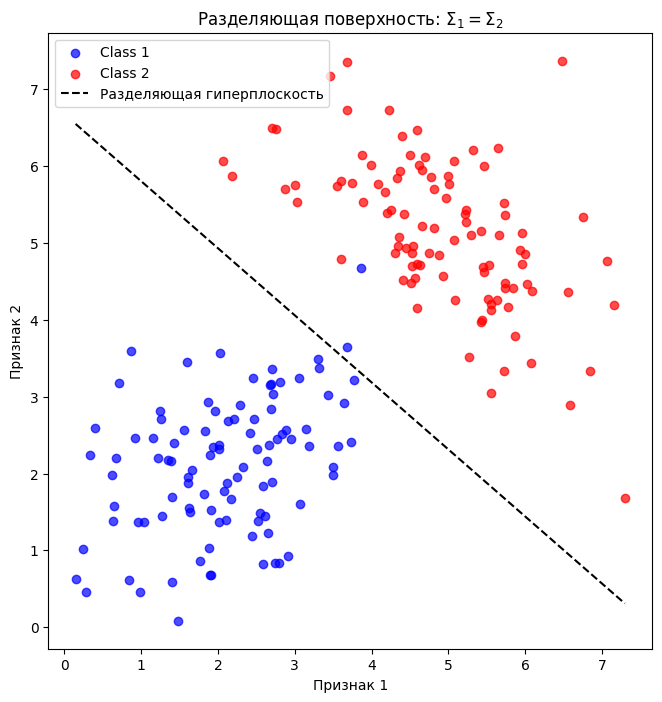

In [ ]:
# Построение разделяющей прямой
x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)


# Координаты y для гиперплоскости
y_vals = (-w[0] * x_vals - b) / w[1]

# Визуализация
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.plot(x_vals, y_vals, label='Разделяющая гиперплоскость', color='black', linestyle = "--")
plt.legend()
plt.title('Разделяющая поверхность: $\Sigma_1 = \Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

Если к данным добавить фиктивный столбец из единиц и в начало вектора весов добавить коэффициент, отвечающий за смещение, то классификатор будет выглядеть следующим образом

In [ ]:
X_stacked = np.hstack((np.array([1]*len(X)).reshape(-1,1), X))
W_stacked = np.hstack((b,w))

def predict(sample, W):
  result = sample @ W
  if result < 0:
    return 1
  return 2

In [ ]:
# Тестовый объект 1
sample_1 = np.array([1,3,2])
# Предсказание класса
predict(sample_1, W_stacked)

1

In [ ]:
# Тестовый объект 2
sample_2 = np.array([1,6,5])
# Предсказание класса
predict(sample_2, W_stacked)

2

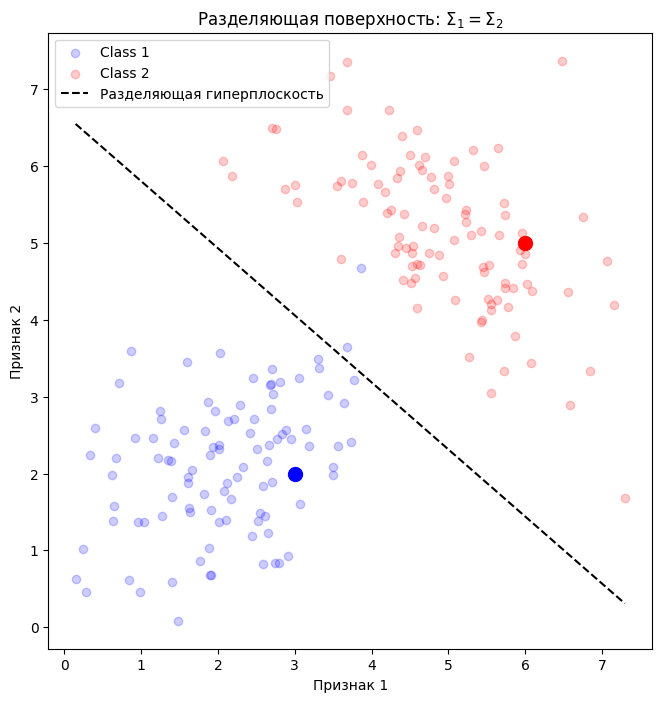

In [ ]:
# Визуализация
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.2)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.2)
plt.scatter(sample_1[1], sample_1[2], s=100, c='blue')
plt.scatter(sample_2[1], sample_2[2], s=100, c='red')
plt.plot(x_vals, y_vals, label='Разделяющая гиперплоскость', color='black', linestyle = "--")
plt.legend()
plt.title('Разделяющая поверхность: $\Sigma_1 = \Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()